In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from grouper import group_by_volume, group_by_time
from pyfolio.timeseries import perf_stats
from functools import partial
from utils import chart_price, plot, v_backtester, c_backtester, perf, perf_var
import sys
sys.path.append('/home/tomek/ib_tools')
from indicators import get_ATR, get_signals
import matplotlib.pyplot as plt
from typing import NamedTuple
from collections import namedtuple
%matplotlib inline

In [2]:
from datastore_pytables import Store

In [3]:
store = Store()
store.keys()

['/cont/min/CL_20191120_NYMEX_USD',
 '/cont/min/ES_20191220_GLOBEX_USD',
 '/cont/min/GC_20191227_NYMEX_USD',
 '/cont/min/GE_20191216_GLOBEX_USD',
 '/cont/min/NKD_20191212_GLOBEX_USD',
 '/cont/min/NQ_20191220_GLOBEX_USD',
 '/cont/min/YM_20191220_ECBOT_USD',
 '/cont/min/ZB_20191219_ECBOT_USD',
 '/cont/min/ZF_20191231_ECBOT_USD',
 '/cont/min/ZN_20191219_ECBOT_USD']

In [4]:
multiplier = 20
#periods = 20
periods = [5, 10, 20, 40, 80, 160,]
ema_fast = 5
ema_slow = 120 # number of periods for moving average filter
#sl_atr = 1 # stop loss in ATRs
atr_periods = 80 # number of periods to calculate ATR on
time_int = 30 # interval in minutes to be used to define volume candle
commission = 2.1 # level of commision per transaction in dollars
bankroll = 15000

In [5]:
contract = store.read('/cont/min/NQ_20191220_GLOBEX_USD').sort_index()
#contract = pd.read_pickle('data/minute_GC_cont_non_active_included.pickle')
contract = contract.loc['20180701': '20181231']
#contract = contract.loc['20190101':]
#contract = contract.loc['20180202': '20180630']
#contract = contract.loc['20190101':]

In [6]:
contract

,open,high,low,close,volume,average,barCount
date,,,,,,,
2018-07-02 00:00:00,7068.25,7078.50,7068.25,7078.25,188,7074.900,135
2018-07-02 00:01:00,7079.00,7079.50,7074.50,7075.25,116,7077.125,82
2018-07-02 00:02:00,7075.75,7080.75,7075.00,7077.75,146,7078.200,88
2018-07-02 00:03:00,7078.50,7078.50,7076.50,7076.75,46,7077.275,33
2018-07-02 00:04:00,7077.00,7077.50,7073.00,7075.75,131,7075.450,69
...,...,...,...,...,...,...,...
2018-12-31 22:55:00,6350.75,6352.50,6350.75,6352.50,19,6351.500,16
2018-12-31 22:56:00,6352.50,6353.25,6352.00,6352.50,61,6352.725,36
2018-12-31 22:57:00,6352.50,6353.25,6351.75,6351.75,17,6352.350,13


In [7]:
#avg_vol = contract.loc['20190621':].volume.rolling(time_int).sum().mean()
avg_vol = contract.volume.rolling(time_int).sum().mean()
avg_vol

10966.867322021164

In [8]:
vol_candles = group_by_volume(contract, avg_vol)
vol_candles['atr'] = get_ATR(vol_candles, atr_periods)

In [9]:
data = vol_candles.copy()
data['ema_fast'] = data.close.ewm(span=ema_fast).mean()
data['ema_slow'] = data.close.ewm(span=ema_slow).mean()
#data['min'] = data.close.rolling(periods).min()
#data['max'] = data.close.rolling(periods).max()
rows_to_drop = max(*periods, ema_slow)
#rows_to_drop = max(periods, ema_fast)
data = data.iloc[rows_to_drop:]
data.reset_index(drop=True, inplace=True)

In [10]:
#data['buy_signal'] = (data.close >= data['max']) * 1
#data['sell_signal'] = (data.close <= data['min']) * -1
#data['signal'] = data.buy_signal + data.sell_signal
#del data['buy_signal']
#del data['sell_signal']
data['signal'] = get_signals(data.close, periods)
data['filter'] = np.sign(data['ema_fast'] - data['ema_slow'])
data['filtered_signal'] = data['signal'] * ((data['signal'] * data['filter']) == 1)
#data['filtered_signal'] = data['signal']

In [11]:
data.rename(columns={'open': 'price'}, inplace=True)

In [12]:
b = c_backtester(data, sl_atr=1, trailing_sl=True, active_close=True, block_stop=False, take_profit=0)
#results_c = perf(b, multiplier, bankroll) 

Annual return                  0.308748
Cumulative returns             0.144005
Annual volatility              0.115491
Sharpe ratio                    2.38813
Calmar ratio                    5.86243
Stability                      0.827619
Max drawdown                 -0.0526655
Omega ratio                     1.54982
Sortino ratio                   4.20318
Skew                           0.499342
Kurtosis                        1.05234
Tail ratio                      1.44799
Daily value at risk           -0.013456
Win percent                    0.447761
Average gain                    41.1333
Average loss                   -23.8671
Avg gain/loss ratio             1.72343
Position EV                     5.23756
Positions per day               1.59524
Days per position              0.626866
Actual avg. duration    0 days 05:43:00
Days                                126
Positions                           201
Trades                              402
Monthly EV                      175.458


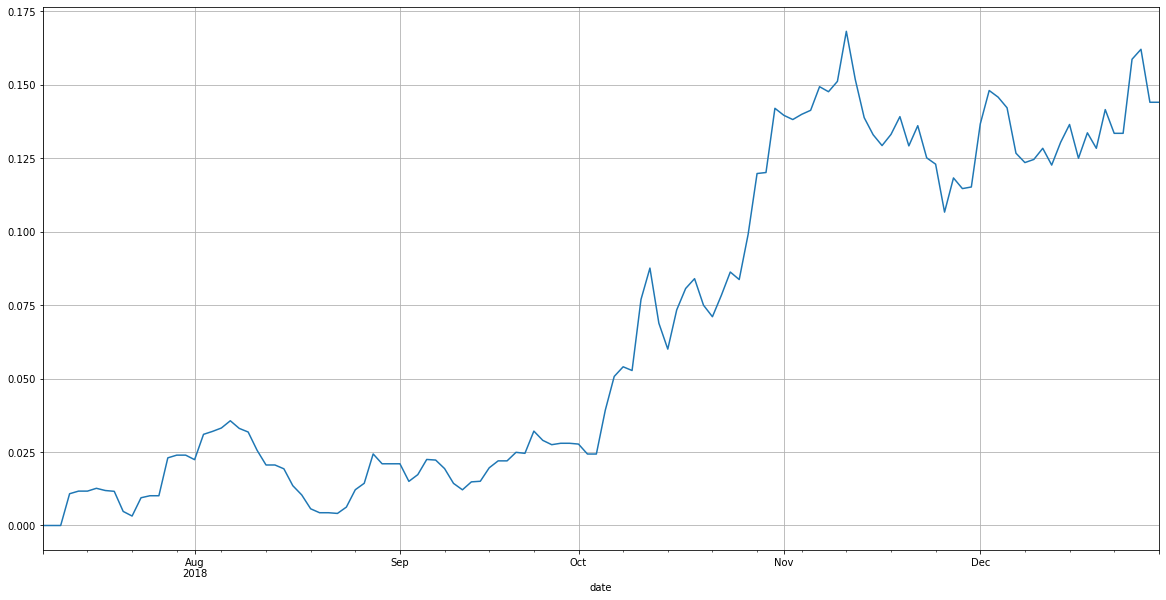

In [13]:
results = perf(b) 

In [14]:
prices = data.set_index('date').close.resample('B').last()
returns = prices.pct_change().fillna(0)
vols_returns = returns.ewm(span=5).std()
vols_prices = vols_returns * prices

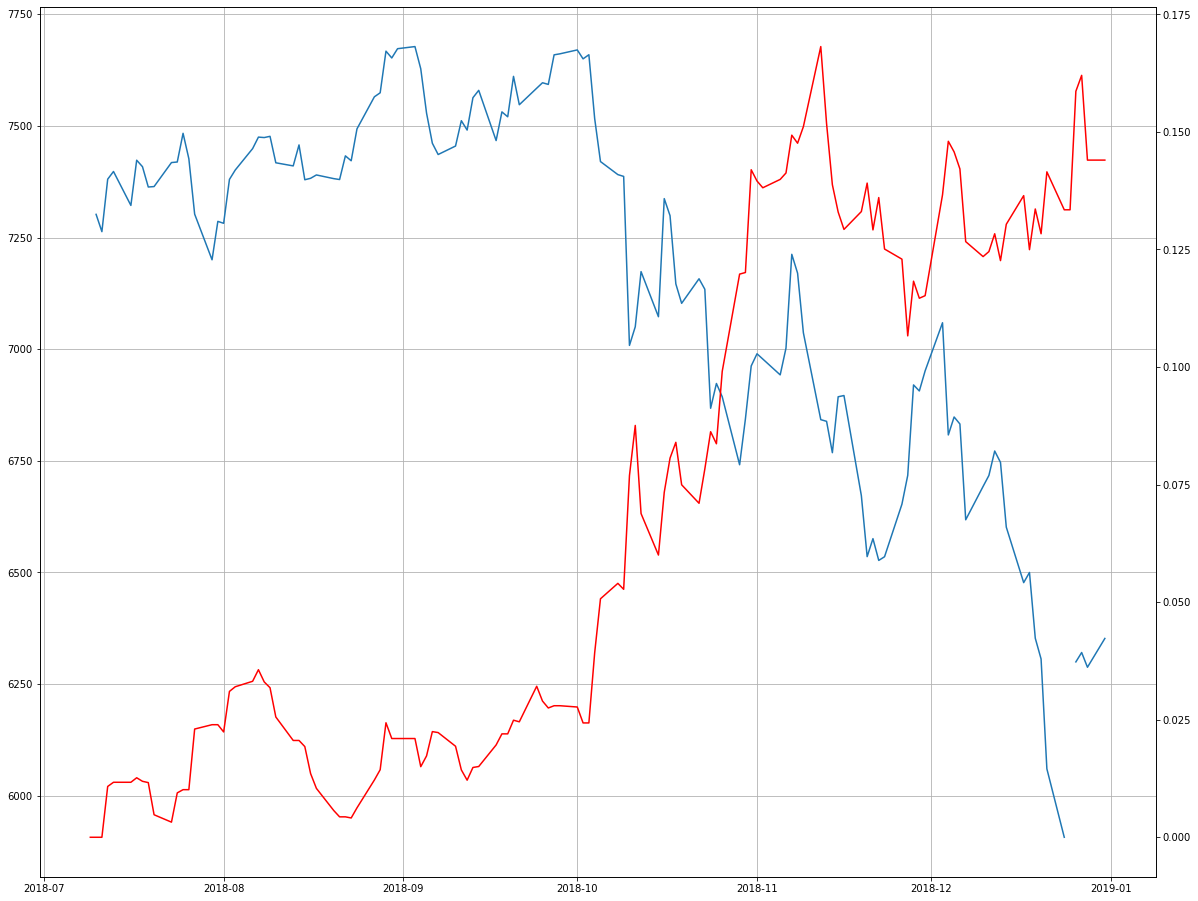

In [15]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20, 16))
ax = fig.add_subplot(111)
ax.plot(prices)
ax1 = ax.twinx()
ax1.plot(results.daily.path, color='red')
ax.grid()
plt.show();

In [16]:
monthly = pd.DataFrame({'open': results.daily.balance.resample('M').first(),
                        'close': results.daily.balance.resample('M').last()})
monthly['c'] = monthly['close'].shift().fillna(monthly['open'].iloc[0])
monthly['pnl'] = monthly['close'] - monthly['c']
del monthly['open']
monthly.columns = ['close', 'open', 'pnl']
monthly

,close,open,pnl
date,,,
2018-07-31,7485.50,7310.50,175.00
2018-08-31,7464.00,7485.50,-21.50
2018-09-30,7515.00,7464.00,51.00
2018-10-31,8348.25,7515.00,833.25
2018-11-30,8152.50,8348.25,-195.75
2018-12-31,8363.25,8152.50,210.75


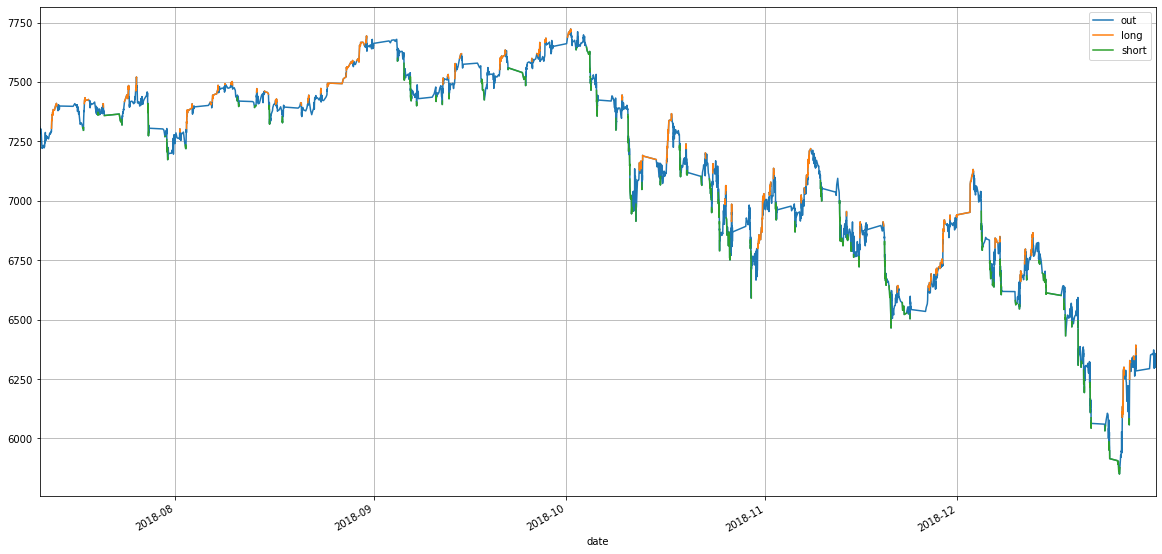

In [17]:
a = chart_price(b['price'], b['position'])

In [18]:
results.positions.head(20)

,date_o,open,date_c,close,reason,pnl,duration
0,2018-07-12 15:52:00,7305.25,2018-07-13 14:33:00,-7390.75,stop-out,85.50,0 days 22:41:00
1,2018-07-17 12:55:00,-7307.25,2018-07-17 15:40:00,7315.50,stop-out,-8.25,0 days 02:45:00
2,2018-07-17 18:32:00,7409.25,2018-07-18 14:00:00,-7419.00,stop-out,9.75,0 days 19:28:00
3,2018-07-19 21:39:00,-7361.50,2018-07-20 03:36:00,7386.75,stop-out,-25.25,0 days 05:57:00
4,2018-07-20 17:01:00,7406.25,2018-07-20 18:48:00,-7379.50,stop-out,-26.75,0 days 01:47:00
5,2018-07-20 21:58:00,-7359.00,2018-07-23 15:37:00,7348.75,stop-out,10.25,2 days 17:39:00
6,2018-07-23 15:50:00,-7323.25,2018-07-23 16:16:00,7345.00,stop-out,-21.75,0 days 00:26:00
7,2018-07-24 01:20:00,7418.00,2018-07-24 17:06:00,-7463.50,stop-out,45.50,0 days 15:46:00
8,2018-07-25 19:37:00,7472.25,2018-07-25 22:36:00,-7477.25,stop-out,5.00,0 days 02:59:00
9,2018-07-27 16:24:00,-7392.50,2018-07-27 19:58:00,7298.25,stop-out,94.25,0 days 03:34:00


In [19]:
#results.daily.to_pickle('nkd_23_2018.pickle')

In [20]:
gc = pd.read_pickle('gc_30.pickle')
nq = pd.read_pickle('nq_30.pickle')
nkd = pd.read_pickle('nkd_30.pickle')

In [21]:
comp = pd.DataFrame({'gc': gc['returns'],
                    'nq': nq['returns'],
                    'nkd': nkd['returns']})
comp

,gc,nq,nkd
date,,,
2018-02-01,NaN,NaN,0.000000
2018-02-02,NaN,NaN,0.000000
2018-02-04,0.000000,NaN,NaN
2018-02-05,0.000000,NaN,0.025486
2018-02-06,0.008853,NaN,-0.004002
...,...,...,...
2019-10-25,0.007231,NaN,0.000000
2019-10-28,0.004494,NaN,0.003538
2019-10-29,-0.000058,NaN,-0.001410


In [22]:
comp.corr()

,gc,nq,nkd
gc,1.000000,0.760807,0.075941
nq,0.760807,1.000000,0.125170
nkd,0.075941,0.125170,1.000000
